In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import _pickle as pickle
import random

In [5]:
claims_path = "/Users/xxz005/Desktop/Raw_Data/PFK_Jan 2009 - Jul 2017/Claims.txt"
Eligibility_path = "/Users/xxz005/Desktop/RAW_DATA/PFK_Jan 2009 - Jul 2017/Eligibility.txt"
Rxclaims_path = "/Users/xxz005/Desktop/Raw_Data/PFK_Jan 2009 - Jul 2017/Rxclaims.txt"

In [3]:
def process(claims_path, year_list):
    pid_svcdt_map = {}
    svcdt_info_map = {}
    pid_dob_map = {}
    pid_gender_map = {}
    pid_zip_map = {}
    
    with open(claims_path) as infile:
        next(infile)
        for i,line in enumerate(infile):
            line=line.split("|")
            
            # Temporal
            svcdt = line[27][:9]
            if svcdt[-4:] not in year_list:continue
            svcenddt = line[28][:9]
            
            # claim 
            pid = line[0]
            claimtype = line[71]            
            
            # Medical
            diag1 = line[13] #diag1~3 only 
            diag2 = line[14]
            diag3 = line[15]
            proc = line[21]
            GrouperDRG = line[63]
            APR_DRG = line[131]
            
            # Utilization
            payorid = line[3]
            PCPID = line[4]
            provid = line[36]
            majcat = line[39]
            eradmit = line[50]
            submit = line[44]
            paid = line[46]
            
            svcdt_pid = svcdt+"||"+pid
            info = [svcdt, svcenddt,                                                     # temporal
                    diag1, diag2, diag3, proc, GrouperDRG, APR_DRG,                      # medical
                    claimtype, payorid, PCPID, provid, majcat, eradmit, submit, paid]    # utilization
            
            if pid not in pid_svcdt_map:
                pid_svcdt_map[pid] = set([svcdt_pid])
            else:
                pid_svcdt_map[pid].add(svcdt_pid)
                
            if svcdt_pid not in svcdt_info_map:
                svcdt_info_map[svcdt_pid] = [info]
            else:
                svcdt_info_map[svcdt_pid].append(info)  
            
            # Demographic
            if len(line[51])<4:continue
            
            dob=line[51][:9]
            gender = line[10]
            Zip = line[5]
            Age = line[9]
            
            if pid not in pid_dob_map: 
                pid_dob_map[pid] = [dob]
            else:
                pid_dob_map[pid].append(dob)
            
            if pid not in pid_gender_map: 
                pid_gender_map[pid] = [gender]
            else:
                pid_gender_map[pid].append(gender)
            
            if pid not in pid_zip_map: 
                pid_zip_map[pid] = [Zip]
            else:
                pid_zip_map[pid].append(Zip)
                
    return pid_svcdt_map, svcdt_info_map, pid_dob_map, pid_gender_map, pid_zip_map

In [4]:
startTime = datetime.now()

pid_svcdt_map, svcdt_info_map, pid_dob_map, pid_gender_map, pid_zip_map = process(claims_path, ["2013", "2014"])

print(datetime.now() - startTime)

0:10:53.883365


In [5]:
def processRX(claims_path, year_list):
    pid_svcdt_map = {}
    svcdt_info_map = {}
    
    with open(claims_path) as infile:
        next(infile)
        for i,line in enumerate(infile):
            line=line.split("|")
            
            # Temporal
            svcdt = line[7][:9]
            if svcdt[-4:] not in year_list:continue
            
            # claim 
            pid = line[0]
            claimtype = "RX"          
            
            # Medical
            NDC = line[12] 
            Drugname = line[13]
            DrugClass = line[16]
            
            # Utilization
            Supply = "Supply_"+ str(line[8])
            Pharmname = line[23]
            payorid = line[2]
            paid = line[19]
            
            svcdt_pid = svcdt+"||"+pid
            info = [svcdt,                                         # temporal
                    NDC, Drugname, DrugClass,                      # medical
                    Supply, Pharmname, payorid, paid]              # utilization
            
            if pid not in pid_svcdt_map:
                pid_svcdt_map[pid] = set([svcdt_pid])
            else:
                pid_svcdt_map[pid].add(svcdt_pid)
                
            if svcdt_pid not in svcdt_info_map:
                svcdt_info_map[svcdt_pid] = [info]
            else:
                svcdt_info_map[svcdt_pid].append(info)  
            
    return pid_svcdt_map, svcdt_info_map

In [6]:
startTime = datetime.now()

pid_svcdt_map_RX, svcdt_info_map_RX = processRX(Rxclaims_path, ["2013", "2014"])

print(datetime.now() - startTime)

0:06:54.254998


In [5]:
def eli_extract(path):
    pid_eli_map = {}
    with open(path) as infile:
        next(infile)
        for line in infile:
            line = line.split('|')
            pid = line[0]
            eli_month = line[1]
            if pid not in pid_eli_map:
                pid_eli_map[pid] = [eli_month]
            else:
                pid_eli_map[pid].append(eli_month)
    return pid_eli_map

def check_eli(pid_eli_map, year_list):
    pid_list = []
    for p in pid_eli_map:
        eli_flag=1
        for year in year_list:
            months = [i for i in pid_eli_map[p] if i.startswith(year)]
            if len(months) !=12:
                eli_flag=0
                break
        if eli_flag: pid_list.append(p)
    return pid_list

def age_flag(p, age, year):
    if p not in pid_dob_map:
        return 0
    else:
        return int(pid_dob_map[p][0][-4:]) < year-age

In [6]:
startTime = datetime.now()

pid_eli_map = eli_extract(Eligibility_path)
pid_list = check_eli(pid_eli_map, ["2013", "2014"])
pid_list = [p for p in pid_list if age_flag(p, 2, 2013)]
print("# of eligible patients:", len(pid_list))

print(datetime.now() - startTime)

# of eligible patients: 143102
0:04:49.796674


# Baseline data

In [7]:
startTime = datetime.now()
StartDay = datetime.strptime('01JAN2013', '%d%b%Y')

input_age_seq = []
input_sex_seq = []
input_zip_seq = []

input_cost_seq = []
target_cost_seq = []

input_medical_cost_seq = []
input_pharmacy_cost_seq = []

input_monthly_medical_cost_seq = []
input_monthly_pharmacy_cost_seq = []

for i, pid in enumerate(pid_list):
    input_sex_seq.append(pid_gender_map[pid][0])
    input_age_seq.append(2013 - int(pid_dob_map[pid][0][-4:]))    
    input_zip_seq.append(pid_zip_map[pid][0])
    
    input_cost = 0
    target_cost = 0
    
    input_medical_cost = 0
    input_monthly_medical_cost = [0]*12

    input_pharmacy_cost = 0
    input_monthly_pharmacy_cost = [0]*12
    
    for claim in pid_svcdt_map[pid]:
        claim_cost = 0
        for line_trans in svcdt_info_map[claim]:
            claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
            claim_cost += max(0, float(line_trans[15]))

        if line_trans[0][-4:]=="2013":
            input_cost += claim_cost
            input_medical_cost += claim_cost
            input_monthly_medical_cost[claim_date//31] += claim_cost
        
        elif line_trans[0][-4:]=="2014": 
            target_cost+=claim_cost
    
    if pid in pid_svcdt_map_RX:
        for claim in pid_svcdt_map_RX[pid]:
            claim_cost = 0
            for line_trans in svcdt_info_map_RX[claim]:
                claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
                claim_cost += max(0, float(line_trans[7]))

            if line_trans[0][-4:]=="2013":
                input_cost += claim_cost
                input_pharmacy_cost += claim_cost
                input_monthly_pharmacy_cost[claim_date//31] += claim_cost
        
            elif line_trans[0][-4:]=="2014": 
                target_cost+=claim_cost
    
    input_cost_seq.append(input_cost)
    target_cost_seq.append(target_cost)
    
    input_medical_cost_seq.append(input_medical_cost)
    input_monthly_medical_cost_seq.append(input_monthly_medical_cost)
    
    input_pharmacy_cost_seq.append(input_pharmacy_cost)
    input_monthly_pharmacy_cost_seq.append(input_monthly_pharmacy_cost)
    
print(datetime.now() - startTime)

0:00:17.837396


In [8]:
startTime = datetime.now()

pickle.dump(input_age_seq,open("baseline/input_age_seq","wb"))
pickle.dump(input_sex_seq,open("baseline/input_sex_seq","wb"))
pickle.dump(input_zip_seq,open("baseline/input_zip_seq","wb"))

pickle.dump(input_cost_seq,open("baseline/input_cost_seq","wb"))
pickle.dump(target_cost_seq,open("baseline/target_cost_seq","wb"))

pickle.dump(input_medical_cost_seq,open("baseline/input_medical_cost_seq","wb"))
pickle.dump(input_pharmacy_cost_seq,open("baseline/input_pharmacy_cost_seq","wb"))

print(datetime.now() - startTime)

0:00:00.564442


In [12]:
startTime = datetime.now()

pickle.dump(input_monthly_medical_cost_seq,open("advance/input_monthly_medical_cost_seq","wb"))
pickle.dump(input_monthly_pharmacy_cost_seq,open("advance/input_monthly_pharmacy_cost_seq","wb"))

print(datetime.now() - startTime)

0:00:00.307548


In [13]:
startTime = datetime.now()
StartDay = datetime.strptime('01JAN2013', '%d%b%Y')

input_drugclass = []

for i, pid in enumerate(pid_list):
    input_drug = []
    if pid in pid_svcdt_map_RX:
        claim_drug = []
        for claim in pid_svcdt_map_RX[pid]:
            for line_trans in svcdt_info_map_RX[claim]:
                claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
                drug = line_trans[3]
                claim_drug.append(drug)
        if line_trans[0][-4:]=="2013":
            input_drug.extend(claim_drug)
    input_drugclass.append(input_drug)

print(datetime.now() - startTime)

0:00:40.223590


In [14]:
startTime = datetime.now()

pickle.dump(input_drugclass,open("baseline/input_drugclass","wb"))

print(datetime.now() - startTime)

0:00:00.739142


# Advance data

In [15]:
startTime = datetime.now()
StartDay = datetime.strptime('01JAN2013', '%d%b%Y')

input_drug_seq = []
for i, pid in enumerate(pid_list):
    input_drug = [[] for i in range(12)]
    
    if pid in pid_svcdt_map_RX:
        for claim in pid_svcdt_map_RX[pid]:
            claim_drug = []
            for line_trans in svcdt_info_map_RX[claim]:
                claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
                drug = line_trans[2]
                claim_drug.append(drug)
        if line_trans[0][-4:]=="2013":
            input_drug[claim_date//31].extend(claim_drug)
    input_drug_seq.append(input_drug)

print(datetime.now() - startTime)

0:00:33.471607


In [ ]:
del svcdt_info_map_RX
del pid_svcdt_map_RX

In [ ]:
startTime = datetime.now()
StartDay = datetime.strptime('01JAN2013', '%d%b%Y')

input_diag_seq = []
input_proc_seq = []
input_util_seq = []

for i, pid in enumerate(pid_list):
    if i%10000 == 0: print(i)
    input_diag = [[] for i in range(12)]
    input_proc = [[] for i in range(12)]
    input_util = [[] for i in range(12)]
    
    for claim in pid_svcdt_map[pid]:
        claim_diag = []
        claim_proc = []
        claim_util = []
        for line_trans in svcdt_info_map[claim]:
            claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
            diag1 = line_trans[2]
            proc = line_trans[5]
            claimtype = line_trans[8]
            majcat = line_trans[12]
            
            claim_util.append(majcat)
            claim_util.append(claimtype)
            claim_proc.append(proc)
            claim_diag.append(diag1)
            
        if line_trans[0][-4:]=="2013":
            input_diag[claim_date//31].extend(list(set(claim_diag)))
            input_proc[claim_date//31].extend(list(set(claim_proc)))
            input_util[claim_date//31].extend(list(set(claim_util)))
    
    input_diag_seq.append(input_diag)
    input_proc_seq.append(input_proc)
    input_util_seq.append(input_util)

print(datetime.now() - startTime)

In [35]:
startTime = datetime.now()

pickle.dump(input_diag_seq,open("advance/input_diag_seq","wb"))
pickle.dump(input_proc_seq,open("advance/input_proc_seq","wb"))
pickle.dump(input_util_seq,open("advance/input_util_seq","wb"))
pickle.dump(input_drug_seq,open("advance/input_drug_seq","wb"))

print(datetime.now() - startTime)

0:00:05.552962


# Analysis

In [34]:
input_cost_seq = pickle.load(open("baseline/input_cost_seq","rb"))
target_cost_seq = pickle.load(open("baseline/target_cost_seq","rb"))

In [4]:
input_cost_seq[0]

456.75

In [5]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [6]:
rank_2013 = np.array([x/len(input_cost_seq) for x in ss.rankdata(input_cost_seq)])
rank_2014 = np.array([x/len(target_cost_seq) for x in ss.rankdata(target_cost_seq)])

In [7]:
scipy.stats.pearsonr(rank_2013, rank_2014)[0]

0.5312548647257245

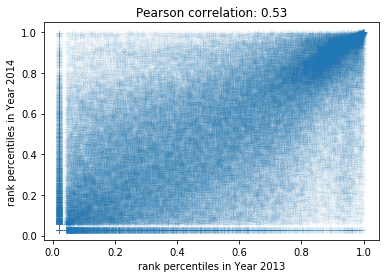

In [35]:
plt.plot(rank_2013, rank_2014, "+", alpha=0.03)
plt.ylabel('rank percentiles in Year 2014')
plt.xlabel('rank percentiles in Year 2013')
plt.title("Pearson correlation: 0.53")
plt.savefig("fig8",dpi=300)
plt.show()

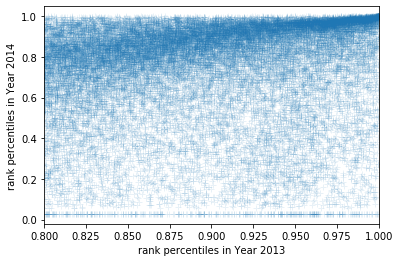

In [9]:
plt.plot(rank_2013, rank_2014, "+", alpha=0.1)
plt.xlim(0.8,1)
plt.ylabel('rank percentiles in Year 2014')
plt.xlabel('rank percentiles in Year 2013')
plt.show()

In [11]:
cost_2013 = input_cost_seq
cost_2014 = target_cost_seq

In [12]:
log_cost_2013 = [np.log(x+1) for x in cost_2013]
log_cost_2014 = [np.log(x+1) for x in cost_2014]

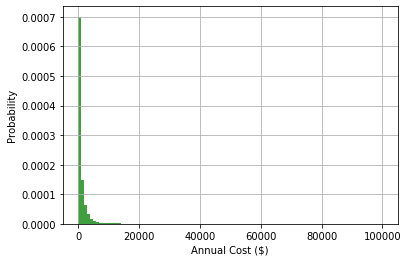

In [13]:
n, bins, patches = plt.hist([100000 if x > 100000 else x for x in cost_2014], 100, density=1, facecolor='g', alpha=0.75)
plt.ylabel('Probability')
plt.xlabel('Annual Cost ($)')
plt.grid(True)
plt.show()

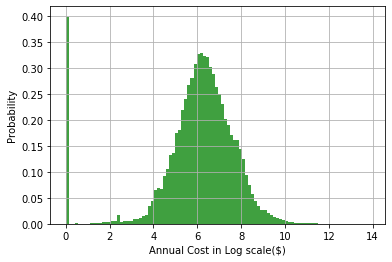

In [14]:
n, bins, patches = plt.hist(log_cost_2014, 100, facecolor='g', density=1, alpha=0.75)
plt.ylabel('Probability')
plt.xlabel('Annual Cost in Log scale($)')
plt.grid(True)
plt.show()

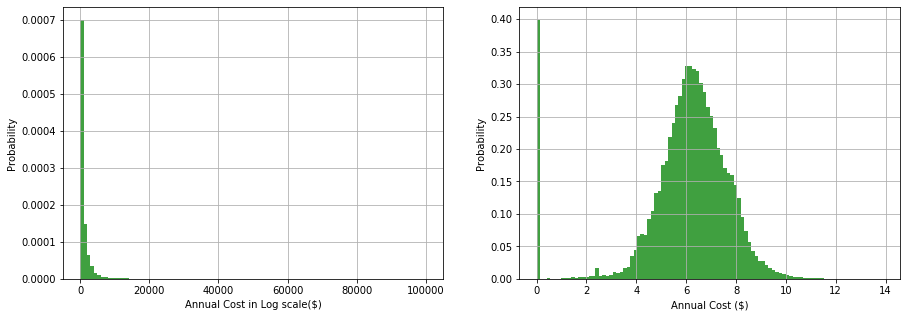

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

n, bins, patches = ax1.hist([100000 if x > 100000 else x for x in cost_2014], 100, density=1, facecolor='g', alpha=0.75)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Annual Cost in Log scale($)')
ax1.grid(True)

n, bins, patches = ax2.hist(log_cost_2014, 100, facecolor='g', density=1, alpha=0.75)
ax2.set_ylabel('Probability')
ax2.set_xlabel('Annual Cost ($)')
ax2.grid(True)

fig.savefig('myimage', dpi=300)
plt.show()